In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3c
commitnumber = a22ab94
conc = 0.0008
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 300
vmax = 800
vmin = 720
w_diffuse = [(1.7, 1.6, 1.8), (1.8, 1.7), (1.5, 1.6, 1.7, 1.8)]
wgt = [(0.6, 0.4, 0.7), (0.7, 0.4), (0.3, 0.4, 0.85, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

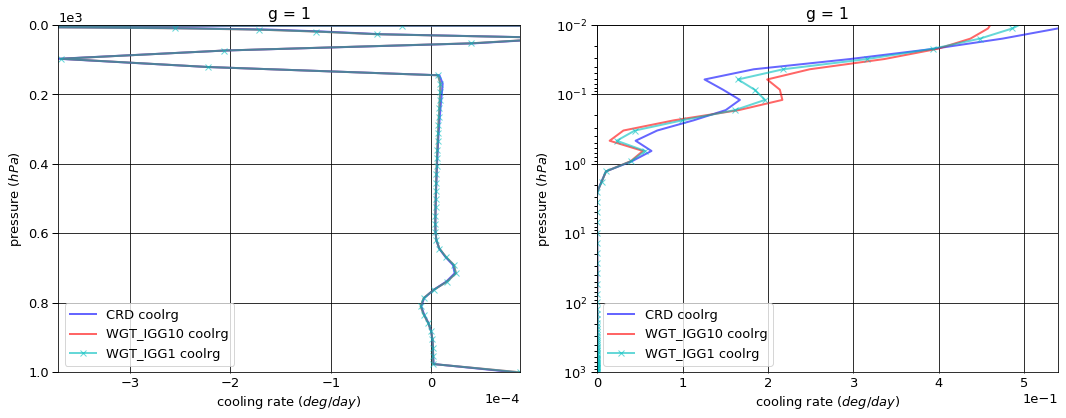

# Figure: cooling rate g-group 2

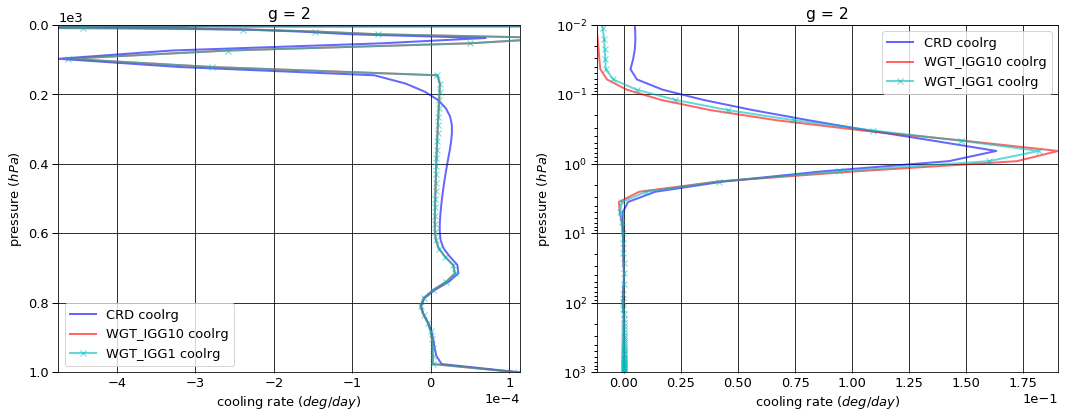

# Figure: cooling rate g-group 3

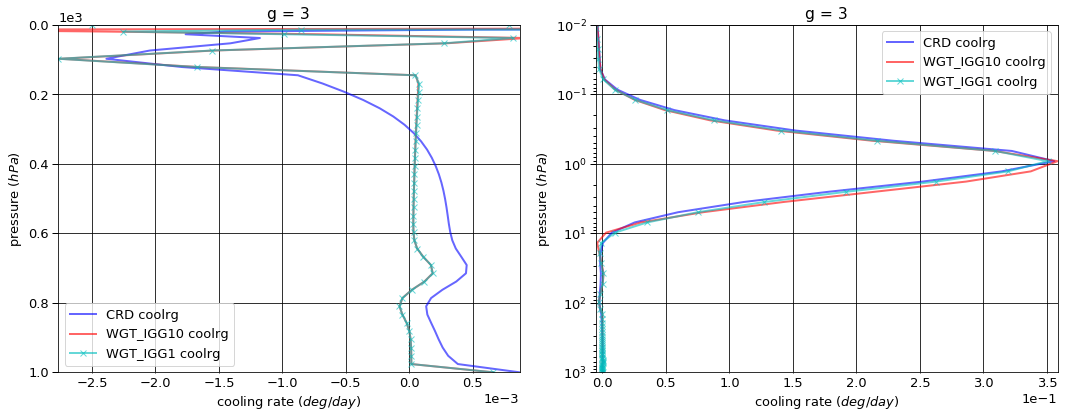

# Figure: cooling rate g-group 4

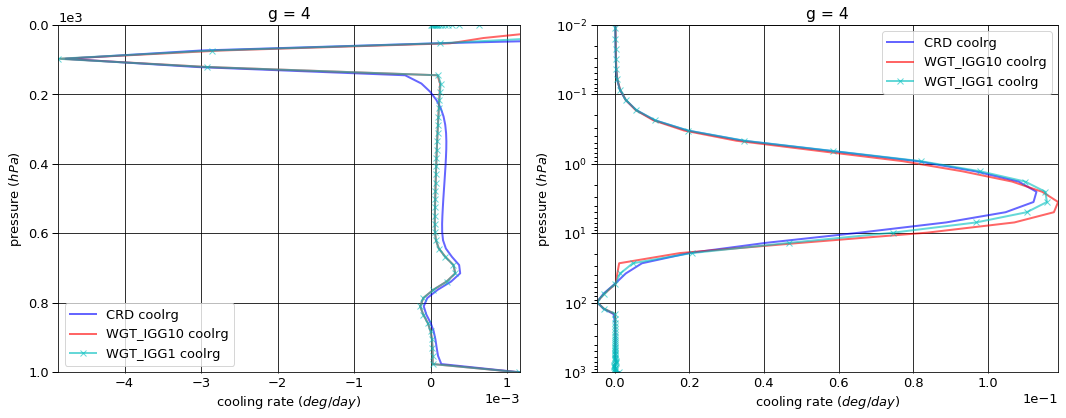

# Figure: cooling rate g-group 5

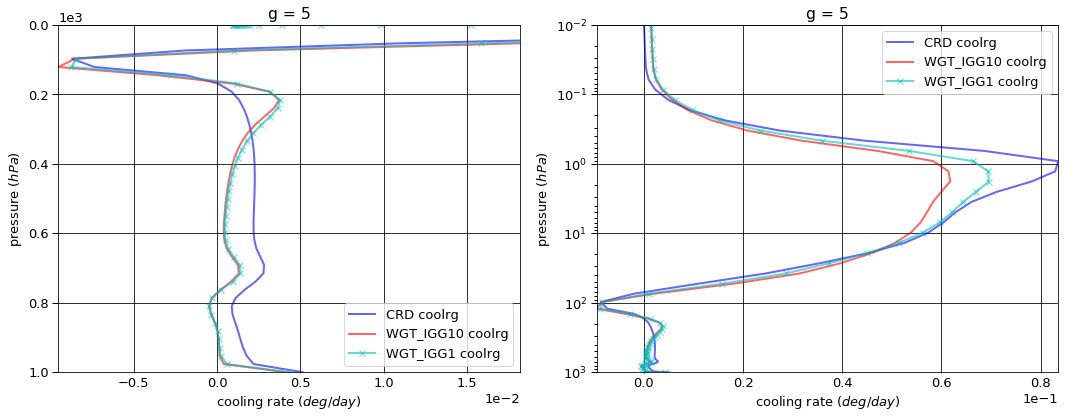

# Figure: cooling rate g-group 6

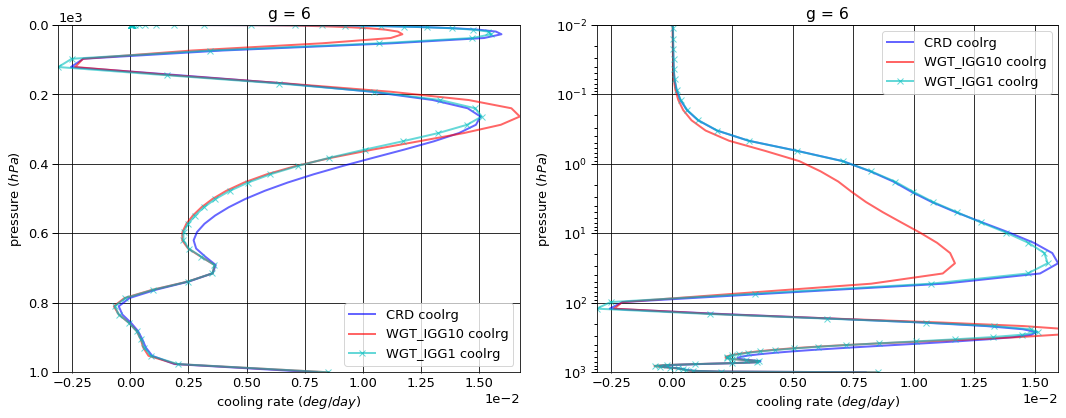

# Figure: cooling rate g-group 7

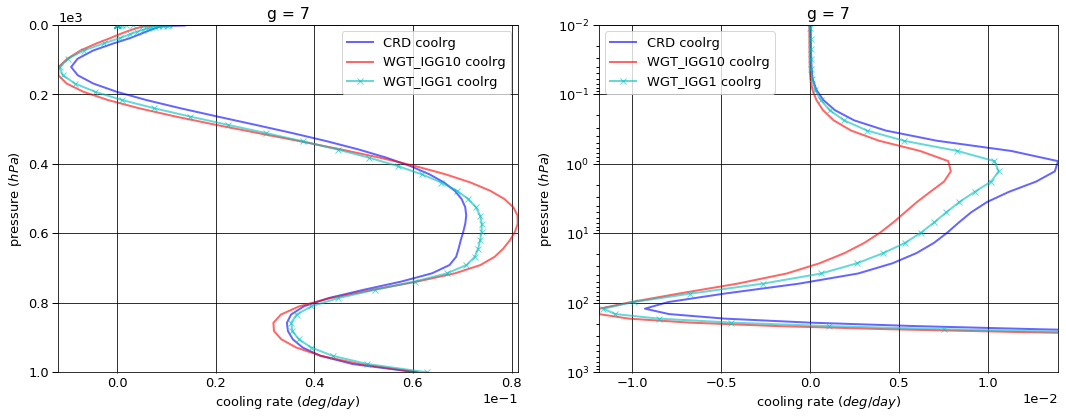

# Figure: cooling rate g-group 8

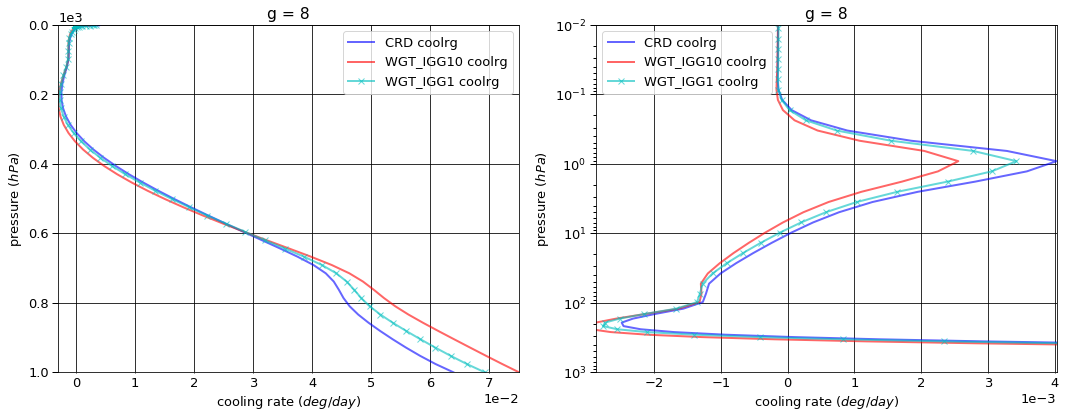

# Figure: cooling rate g-group 9

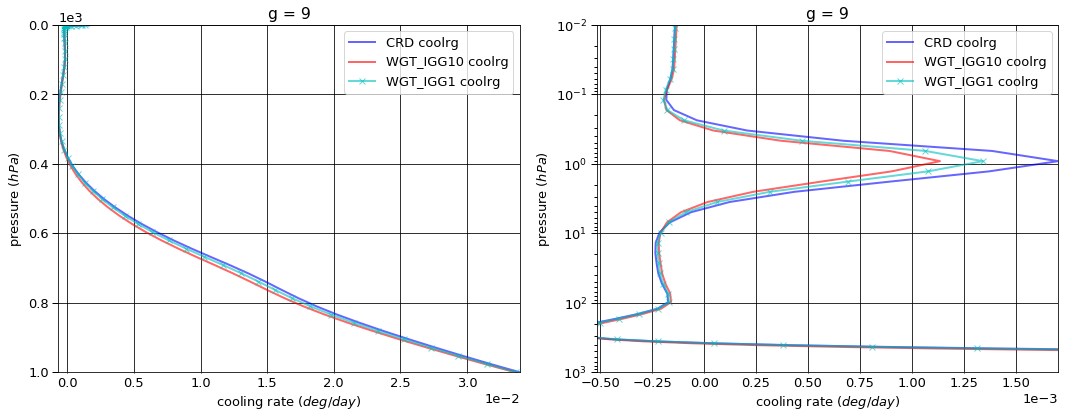

# Figure: cooling rate g-group total

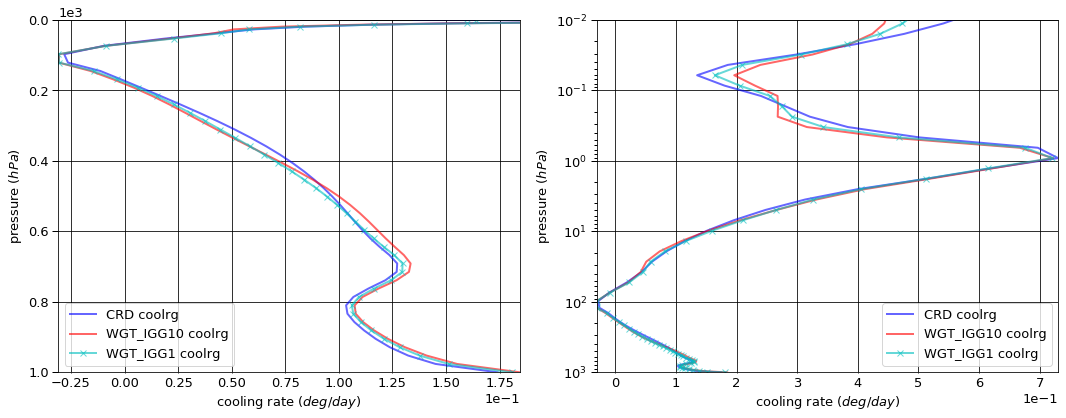

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.010158  0.000000  -0.010158
  1013.0   76     -0.030843  0.030608  -0.000235
2 0.0      1      -0.021646  0.000000  -0.021646
  1013.0   76     -0.038795  0.038430  -0.000365
3 0.0      1      -0.117526  0.000000  -0.117526
  1013.0   76     -0.231886  0.223301  -0.008586
4 0.0      1      -0.155225  0.000000  -0.155225
  1013.0   76     -0.404007  0.399851  -0.004155
5 0.0      1      -0.450817  0.000000  -0.450817
  1013.0   76     -1.383759  1.320252  -0.063506
6 0.0      1      -0.704930  0.000000  -0.704930
  1013.0   76     -2.477124  2.448825  -0.028299
7 0.0      1      -5.444472  0.000000  -5.444472
  1013.0   76    -10.416313  9.728246  -0.688066
8 0.0      1      -6.238534  0.000000  -6.238534
  1013.0   76     -7.501169  3.939167  -3.562002
9 0.0      1     -12.420906  0.000000 -12.420906
  1013.0   76    -12.739615  1.324619 -11.414996


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.009138   0.000000  -0.009138
  1013.0   76     -0.031729   0.031482  -0.000247
2 0.0      1      -0.022505   0.000000  -0.022505
  1013.0   76     -0.039688   0.039379  -0.000309
3 0.0      1      -0.120733   0.000000  -0.120733
  1013.0   76     -0.236426   0.234584  -0.001842
4 0.0      1      -0.158925   0.000000  -0.158925
  1013.0   76     -0.415025   0.411792  -0.003233
5 0.0      1      -0.324945   0.000000  -0.324945
  1013.0   76     -1.409300   1.396768  -0.012532
6 0.0      1      -0.644838   0.000000  -0.644838
  1013.0   76     -2.532171   2.503361  -0.028810
7 0.0      1      -5.402350   0.000000  -5.402350
  1013.0   76    -10.603690  10.003181  -0.600509
8 0.0      1      -6.197479   0.000000  -6.197479
  1013.0   76     -7.467883   4.217542  -3.250341
9 0.0      1     -12.205315   0.000000 -12.205315
  1013.0   76    -12.487597   1.234833 -11.252763


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009347  0.000000  -0.009347
  1013.0   76     -0.031729  0.031482  -0.000247
2 0.0      1      -0.022158  0.000000  -0.022158
  1013.0   76     -0.039688  0.039379  -0.000309
3 0.0      1      -0.118243  0.000000  -0.118243
  1013.0   76     -0.236426  0.234582  -0.001844
4 0.0      1      -0.156720  0.000000  -0.156720
  1013.0   76     -0.415025  0.411792  -0.003233
5 0.0      1      -0.333560  0.000000  -0.333560
  1013.0   76     -1.409300  1.395748  -0.013552
6 0.0      1      -0.645591  0.000000  -0.645591
  1013.0   76     -2.532171  2.502588  -0.029582
7 0.0      1      -5.404628  0.000000  -5.404628
  1013.0   76    -10.603690  9.920087  -0.683604
8 0.0      1      -6.182461  0.000000  -6.182461
  1013.0   76     -7.467883  4.092856  -3.375027
9 0.0      1     -12.188341  0.000000 -12.188341
  1013.0   76    -12.487597  1.281799 -11.205798


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001020  0.000000  0.001020
  1013.0   76    -0.000887  0.000874 -0.000013
2 0.0      1     -0.000859  0.000000 -0.000859
  1013.0   76    -0.000894  0.000950  0.000056
3 0.0      1     -0.003206  0.000000 -0.003206
  1013.0   76    -0.004540  0.011284  0.006744
4 0.0      1     -0.003701  0.000000 -0.003701
  1013.0   76    -0.011018  0.011941  0.000923
5 0.0      1      0.125872  0.000000  0.125872
  1013.0   76    -0.025541  0.076516  0.050975
6 0.0      1      0.060091  0.000000  0.060091
  1013.0   76    -0.055047  0.054537 -0.000511
7 0.0      1      0.042122  0.000000  0.042122
  1013.0   76    -0.187377  0.274935  0.087557
8 0.0      1      0.041055  0.000000  0.041055
  1013.0   76     0.033286  0.278375  0.311661
9 0.0      1      0.215591  0.000000  0.215591
  1013.0   76     0.252018 -0.089786  0.162233


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000811  0.000000  0.000811
  1013.0   76    -0.000887  0.000874 -0.000013
2 0.0      1     -0.000512  0.000000 -0.000512
  1013.0   76    -0.000894  0.000950  0.000056
3 0.0      1     -0.000717  0.000000 -0.000717
  1013.0   76    -0.004540  0.011282  0.006742
4 0.0      1     -0.001496  0.000000 -0.001496
  1013.0   76    -0.011018  0.011941  0.000923
5 0.0      1      0.117257  0.000000  0.117257
  1013.0   76    -0.025541  0.075496  0.049954
6 0.0      1      0.059339  0.000000  0.059339
  1013.0   76    -0.055047  0.053764 -0.001283
7 0.0      1      0.039844  0.000000  0.039844
  1013.0   76    -0.187377  0.191840  0.004463
8 0.0      1      0.056073  0.000000  0.056073
  1013.0   76     0.033286  0.153689  0.186975
9 0.0      1      0.232565  0.000000  0.232565
  1013.0   76     0.252018 -0.042820  0.209198

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.637814
  1001.112500 75     0.000083
2 0.000312    1     -0.001755
  1001.112500 75     0.000114
3 0.000312    1     -0.007458
  1001.112500 75     0.000868
4 0.000312    1      0.000012
  1001.112500 75     0.001167
5 0.000312    1     -0.000375
  1001.112500 75     0.005152
6 0.000312    1      0.000027
  1001.112500 75     0.008019
7 0.000312    1     -0.000031
  1001.112500 75     0.060734
8 0.000312    1     -0.000130
  1001.112500 75     0.063926
9 0.000312    1     -0.000119
  1001.112500 75     0.033963


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.366204
  1001.112500 75     0.000088
2 0.000312    1     -0.015437
  1001.112500 75     0.000111
3 0.000312    1     -0.006847
  1001.112500 75     0.000659
4 0.000312    1      0.000048
  1001.112500 75     0.001157
5 0.000312    1      0.000956
  1001.112500 75     0.004206
6 0.000312    1      0.000024
  1001.112500 75     0.008516
7 0.000312    1     -0.000075
  1001.112500 75     0.060995
8 0.000312    1     -0.000128
  1001.112500 75     0.075040
9 0.000312    1     -0.000110
  1001.112500 75     0.033633


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.464151
  1001.112500 75     0.000088
2 0.000312    1     -0.014108
  1001.112500 75     0.000111
3 0.000312    1     -0.008166
  1001.112500 75     0.000660
4 0.000312    1      0.000009
  1001.112500 75     0.001157
5 0.000312    1      0.000925
  1001.112500 75     0.004346
6 0.000312    1      0.000034
  1001.112500 75     0.008523
7 0.000312    1     -0.000035
  1001.112500 75     0.062817
8 0.000312    1     -0.000124
  1001.112500 75     0.069235
9 0.000312    1     -0.000117
  1001.112500 75     0.033712


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.271610
  1001.112500 75     0.000005
2 0.000312    1     -0.013683
  1001.112500 75    -0.000003
3 0.000312    1      0.000610
  1001.112500 75    -0.000209
4 0.000312    1      0.000036
  1001.112500 75    -0.000009
5 0.000312    1      0.001330
  1001.112500 75    -0.000947
6 0.000312    1     -0.000003
  1001.112500 75     0.000497
7 0.000312    1     -0.000044
  1001.112500 75     0.000261
8 0.000312    1      0.000002
  1001.112500 75     0.011114
9 0.000312    1      0.000008
  1001.112500 75    -0.000331


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.173663
  1001.112500 75     0.000005
2 0.000312    1     -0.012353
  1001.112500 75    -0.000003
3 0.000312    1     -0.000708
  1001.112500 75    -0.000209
4 0.000312    1     -0.000003
  1001.112500 75    -0.000009
5 0.000312    1      0.001300
  1001.112500 75    -0.000806
6 0.000312    1      0.000007
  1001.112500 75     0.000504
7 0.000312    1     -0.000004
  1001.112500 75     0.002083
8 0.000312    1      0.000006
  1001.112500 75     0.005309
9 0.000312    1      0.000002
  1001.112500 75    -0.000252

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.564213,0.000000,-25.564213
1013.0,76,-35.223510,19.453299,-15.770210



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.086228,0.000000,-25.086228
1013.0,76,-35.223510,20.072924,-15.150585



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.061049,0.000000,-25.061049
1013.0,76,-35.223510,19.910314,-15.313195



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,4.779858e-01,0.000000,0.477986
1013.0,76,-4.000000e-09,0.619625,0.619625



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,5.031645e-01,0.000000,0.503165
1013.0,76,-4.000000e-09,0.457015,0.457015


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.627986
1001.112500,75,0.174026



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.344633
1001.112500,75,0.184405



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.442569
1001.112500,75,0.180649



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.283353
1001.112500,75,0.010379



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.185417
1001.112500,75,0.006623


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000850,0.000901
2,0.001075,0.001127
3,0.006450,0.006712
4,0.011150,0.011783
5,0.038525,0.040010
6,0.068675,0.071889
7,0.290038,0.301040
8,0.213775,0.212014
9,0.369463,0.354524


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.310867e-19
2,2.133976e-20
3,1.970626e-21
4,1.774707e-21
5,1.647913e-22
6,5.838237e-22
7,6.101170e-23
8,6.375943e-24
9,2.959058e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.310867e-19,NaN,0.000850,0.000901,0.000850,0.000901,1.0
2,2.133976e-20,0.092345,0.001075,0.001127,0.001925,0.002028,1.0
3,1.970626e-21,0.092345,0.006450,0.006712,0.008375,0.008740,1.0
4,1.774707e-21,0.900580,0.011150,0.011783,0.019525,0.020522,10.0
5,1.647913e-22,0.092856,0.038525,0.040010,0.058050,0.060533,10.0
6,5.838237e-22,3.542806,0.068675,0.071889,0.126725,0.132421,500.0
7,6.101170e-23,0.104504,0.290038,0.301040,0.416763,0.433461,500.0
8,6.375943e-24,0.104504,0.213775,0.212014,0.630537,0.645476,500.0
9,2.959058e-25,0.046410,0.369463,0.354524,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
